In [1]:
import numpy as np
from datetime import datetime
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

sns.set_theme(style='whitegrid')
pl.Config.set_tbl_rows(50)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(100)
warnings.filterwarnings('ignore')

# Data Prepration

In [2]:
df = pl.scan_csv('data/311_Service_Requests_from_2010_to_Present_20231110.csv', ignore_errors=True)

Filter dataset from the year 2019 until present (2023)

In [3]:
df = (
    df.filter(pl.col('Created Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p").dt.year() > 2018)
).collect(streaming=True)

Parse date atributes

In [4]:
df = df.with_columns([
    pl.col('Created Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Closed Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Due Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Resolution Action Updated Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    ])

In [2]:
# df = pl.read_parquet('data/311_Service_Requests_from_2019_to_Present.parquet')

# Attribute Analysis

Missing values

In [7]:
null_df = df.null_count().transpose(include_header=True).rename({'column': 'Column', 'column_0': 'Null Count'})

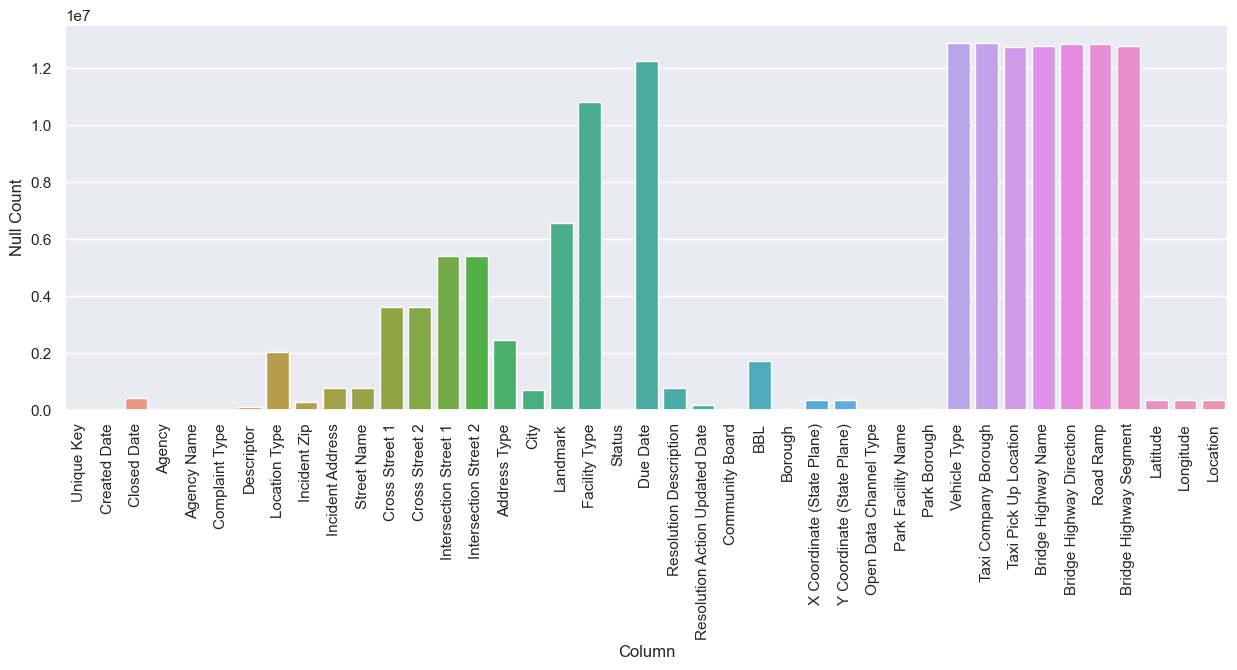

In [24]:
plt.figure(figsize = (15,5))
sns.barplot(data=null_df.to_pandas(), x='Column', y='Null Count')
plt.xticks(rotation=90)
plt.show()

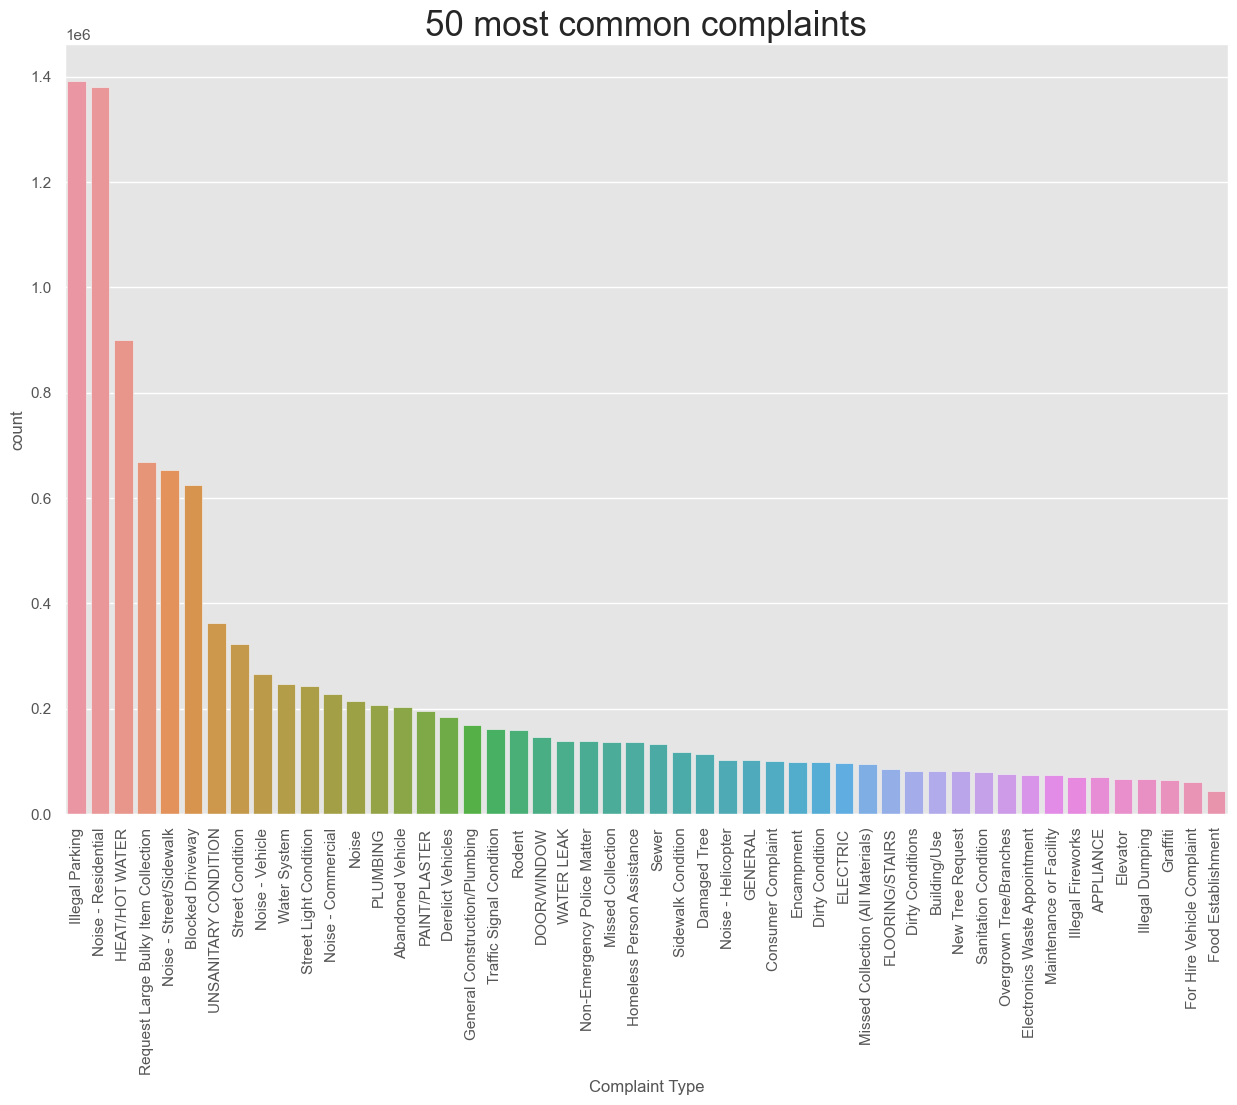

In [10]:
complaints_count = df.group_by('Complaint Type').count().sort('count', descending=True)[:50]
plt.figure(figsize = (15,10))
sns.barplot(data=complaints_count.to_pandas(), x='Complaint Type', y='count', palette='flare')
plt.title('50 most common complaints',fontsize=25)
plt.xticks(rotation=90)
plt.show()

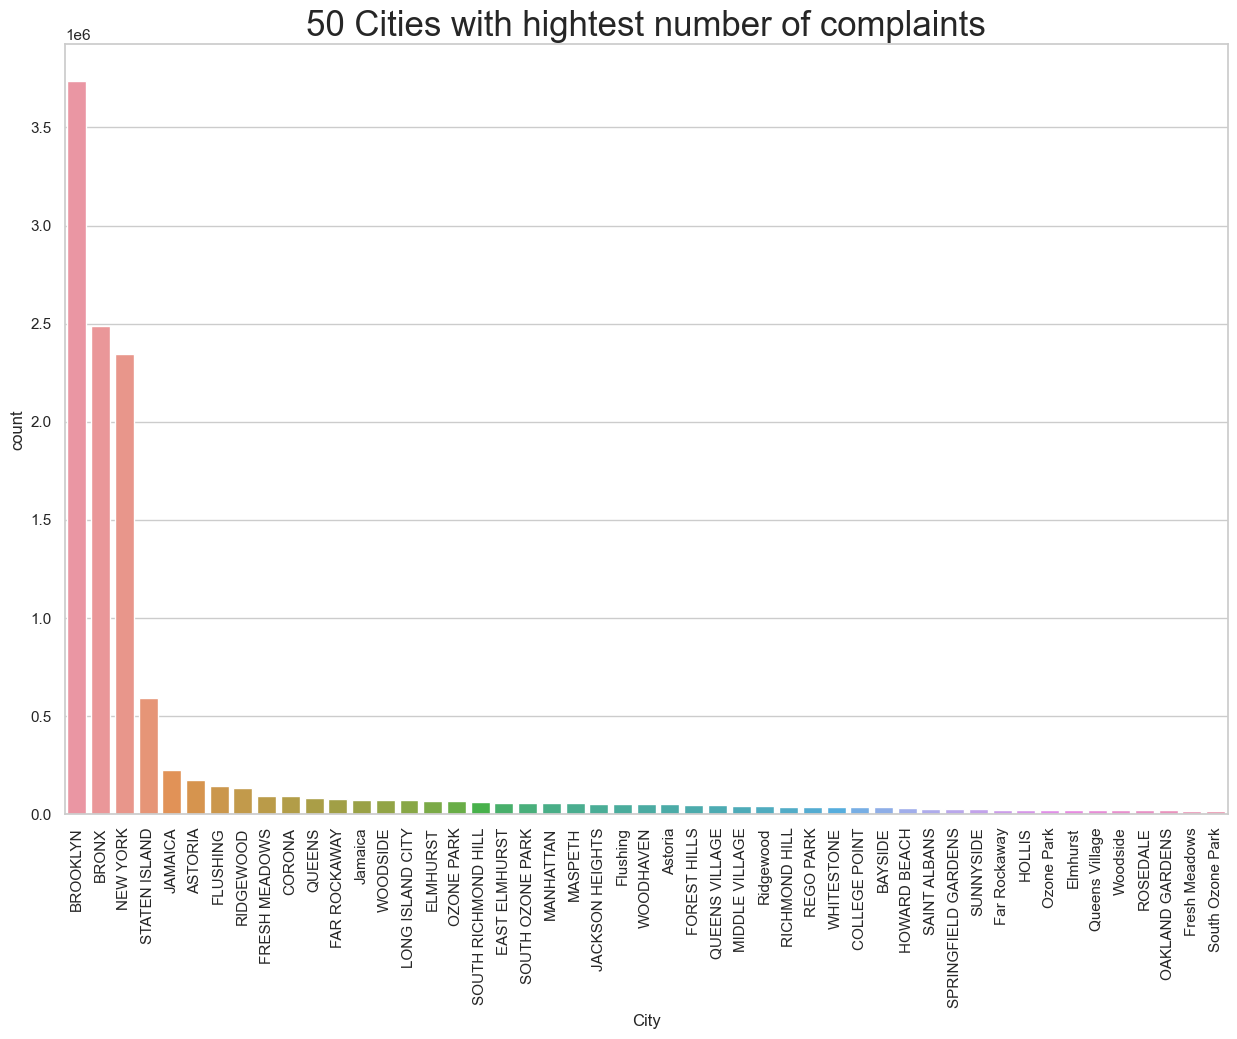

In [26]:
complaints_count = df.group_by('City').count().sort('count', descending=True)[:50]
plt.figure(figsize = (15,10))
sns.barplot(data=complaints_count.to_pandas(), x='City', y='count')
plt.title('50 Cities with hightest number of complaints',fontsize=25)
plt.xticks(rotation=90)
plt.show()

Observed that Brooklyn has the highest number of complaint

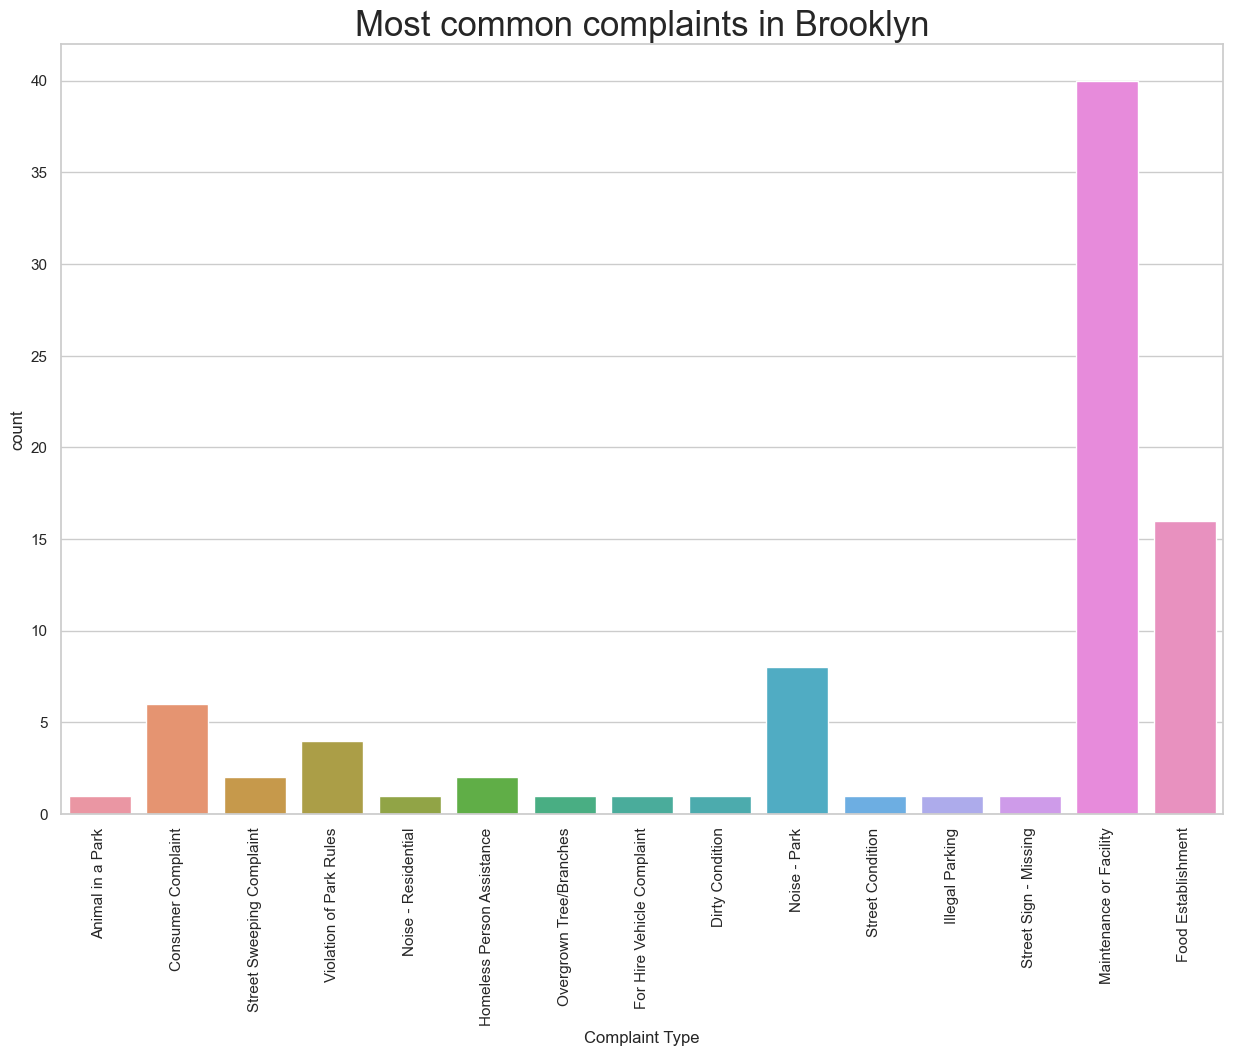

In [27]:
brooklyn_complaint_count = df.filter(pl.col('City') == 'Brooklyn').group_by('Complaint Type').count()
plt.figure(figsize = (15,10))
sns.barplot(data=brooklyn_complaint_count.to_pandas(), x='Complaint Type', y='count')
plt.title('Most common complaints in Brooklyn',fontsize=25)
plt.xticks(rotation=90)
plt.show()

Complaint distridution across Boroughs

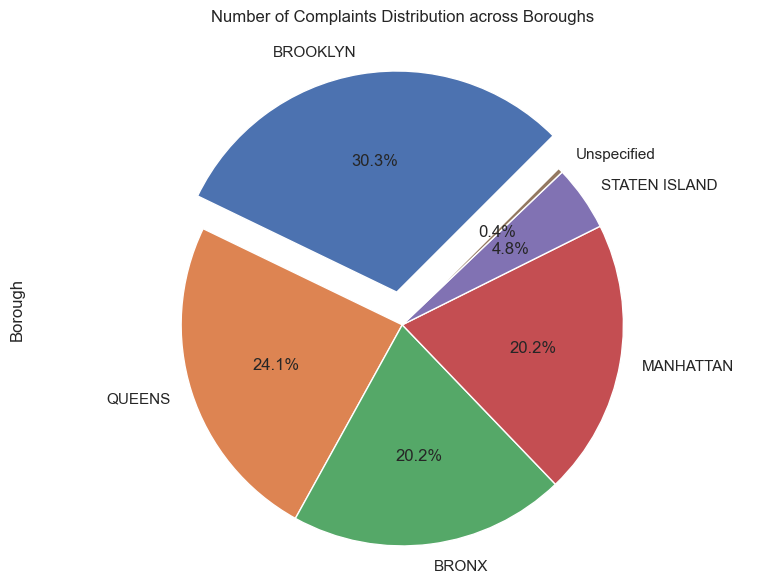

In [70]:
df.to_pandas()['Borough'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                        explode = (0.15, 0, 0, 0, 0, 0), startangle=45, shadow=False,
                        figsize = (8,6))

plt.axis('equal')
plt.title('Number of Complaints Distribution across Boroughs\n')
plt.tight_layout()
plt.show()

### Issue heatmap by location

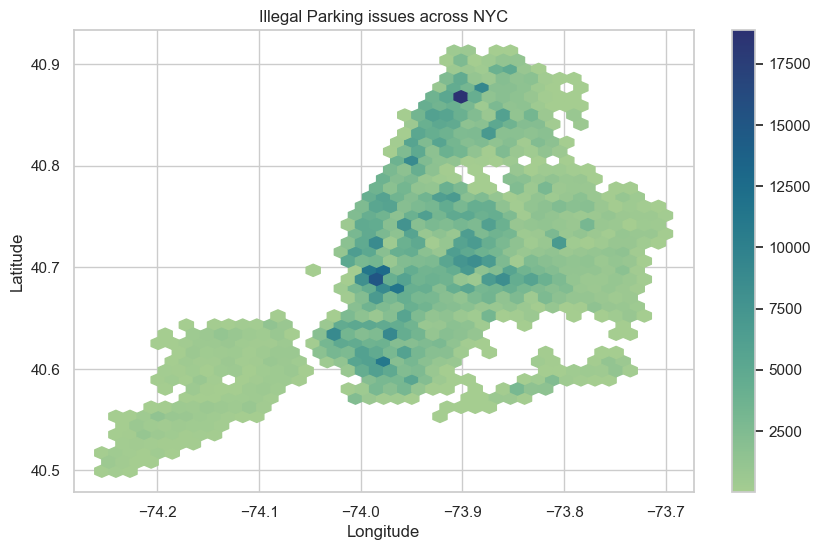

In [61]:
df_temp = df.filter(pl.col('Complaint Type') == 'Illegal Parking')
df_temp.to_pandas().plot(kind='hexbin', 
                        x='Longitude', 
                        y='Latitude', 
                        gridsize=40,
                        colormap='crest',
                        mincnt=1,
                        title='Illegal Parking issues across NYC',
                        figsize=(10,6)).axis('equal')
plt.show()

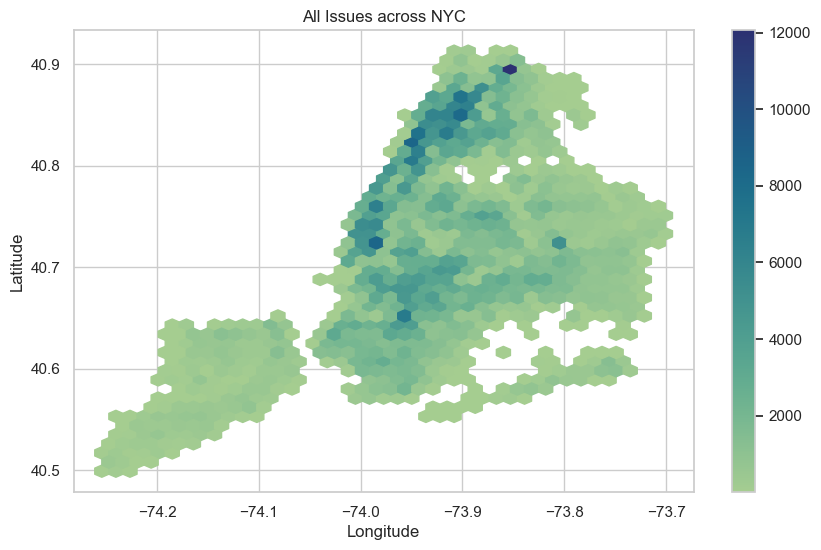

In [66]:
df.sample(1000000).to_pandas().plot(kind='hexbin', 
                        x='Longitude', 
                        y='Latitude', 
                        gridsize=40,
                        colormap='crest',
                        mincnt=1,
                        title='All Issues across NYC',
                        figsize=(10,6)).axis('equal')
plt.show()

### Average of Response time (#days from an issue's created date to closed date)

10 Complaint Types with slowest response time

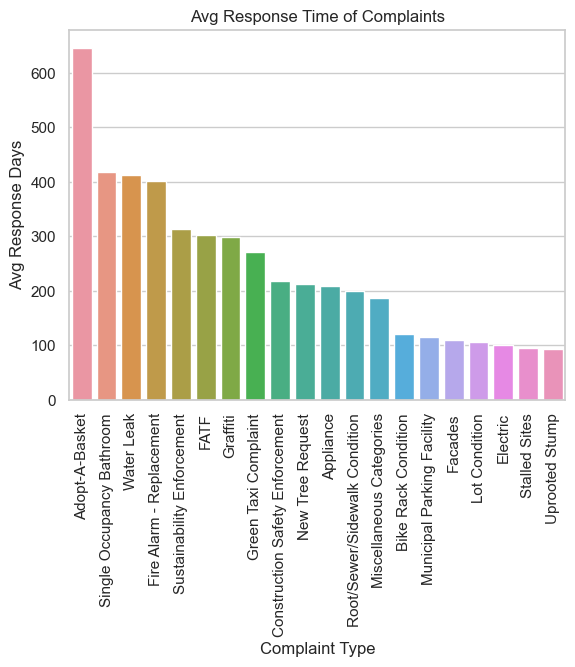

In [21]:
df_temp = df.group_by('Complaint Type').agg((pl.col('Closed Date') - pl.col('Created Date')).dt.days().mean().alias('Avg Response Days')).sort('Avg Response Days', descending=True).head(20)
sns.barplot(data=df_temp.to_pandas(), x='Complaint Type', y='Avg Response Days')
plt.xticks(rotation=90)
plt.title('Avg Response Time of Complaints')
plt.show()

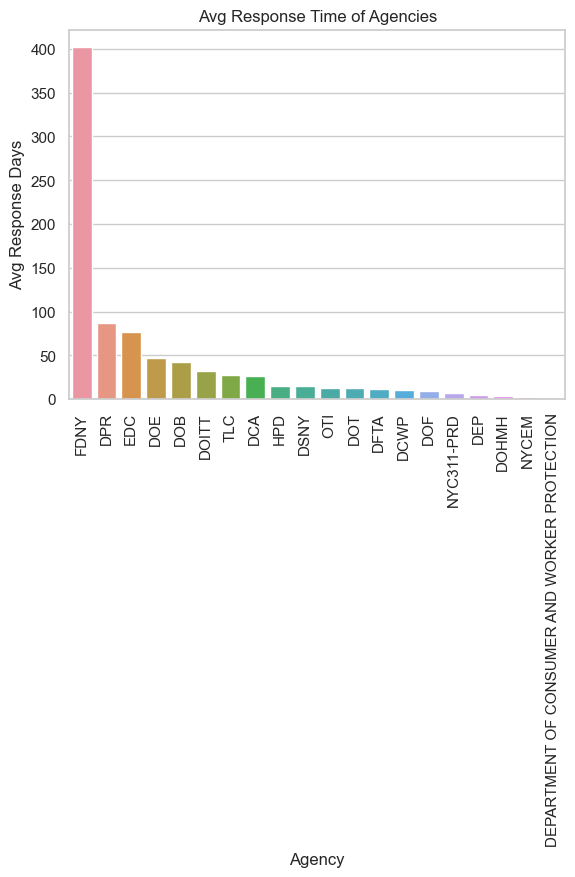

In [22]:
df_temp = df.group_by('Agency').agg((pl.col('Closed Date') - pl.col('Created Date')).dt.days().mean().alias('Avg Response Days')).sort('Avg Response Days', descending=True).head(20)
sns.barplot(data=df_temp.to_pandas(), x='Agency', y='Avg Response Days')
plt.xticks(rotation=90)
plt.title('Avg Response Time of Agencies')
plt.show()

Landmark

In [10]:
print(f"There is {df.filter(pl.col('Landmark').is_not_null()).shape[0]} service requests with incident locations marked as landmarks")

There is 6293866 service requests with incident locations marked as landmarks


Top 5 landmarks with most frequent complaints

In [4]:
df['Landmark'].value_counts().filter(pl.col('Landmark').is_not_null()).sort('counts', descending=True).head(5)

Landmark,counts
str,u32
"""EAST 231 STREET""",120987
"""BROADWAY""",79178
"""5 AVENUE""",41650
"""PARSONS BOULEVARD""",37614
"""GRAND CONCOURSE""",32666


Volume of Daily Calls 

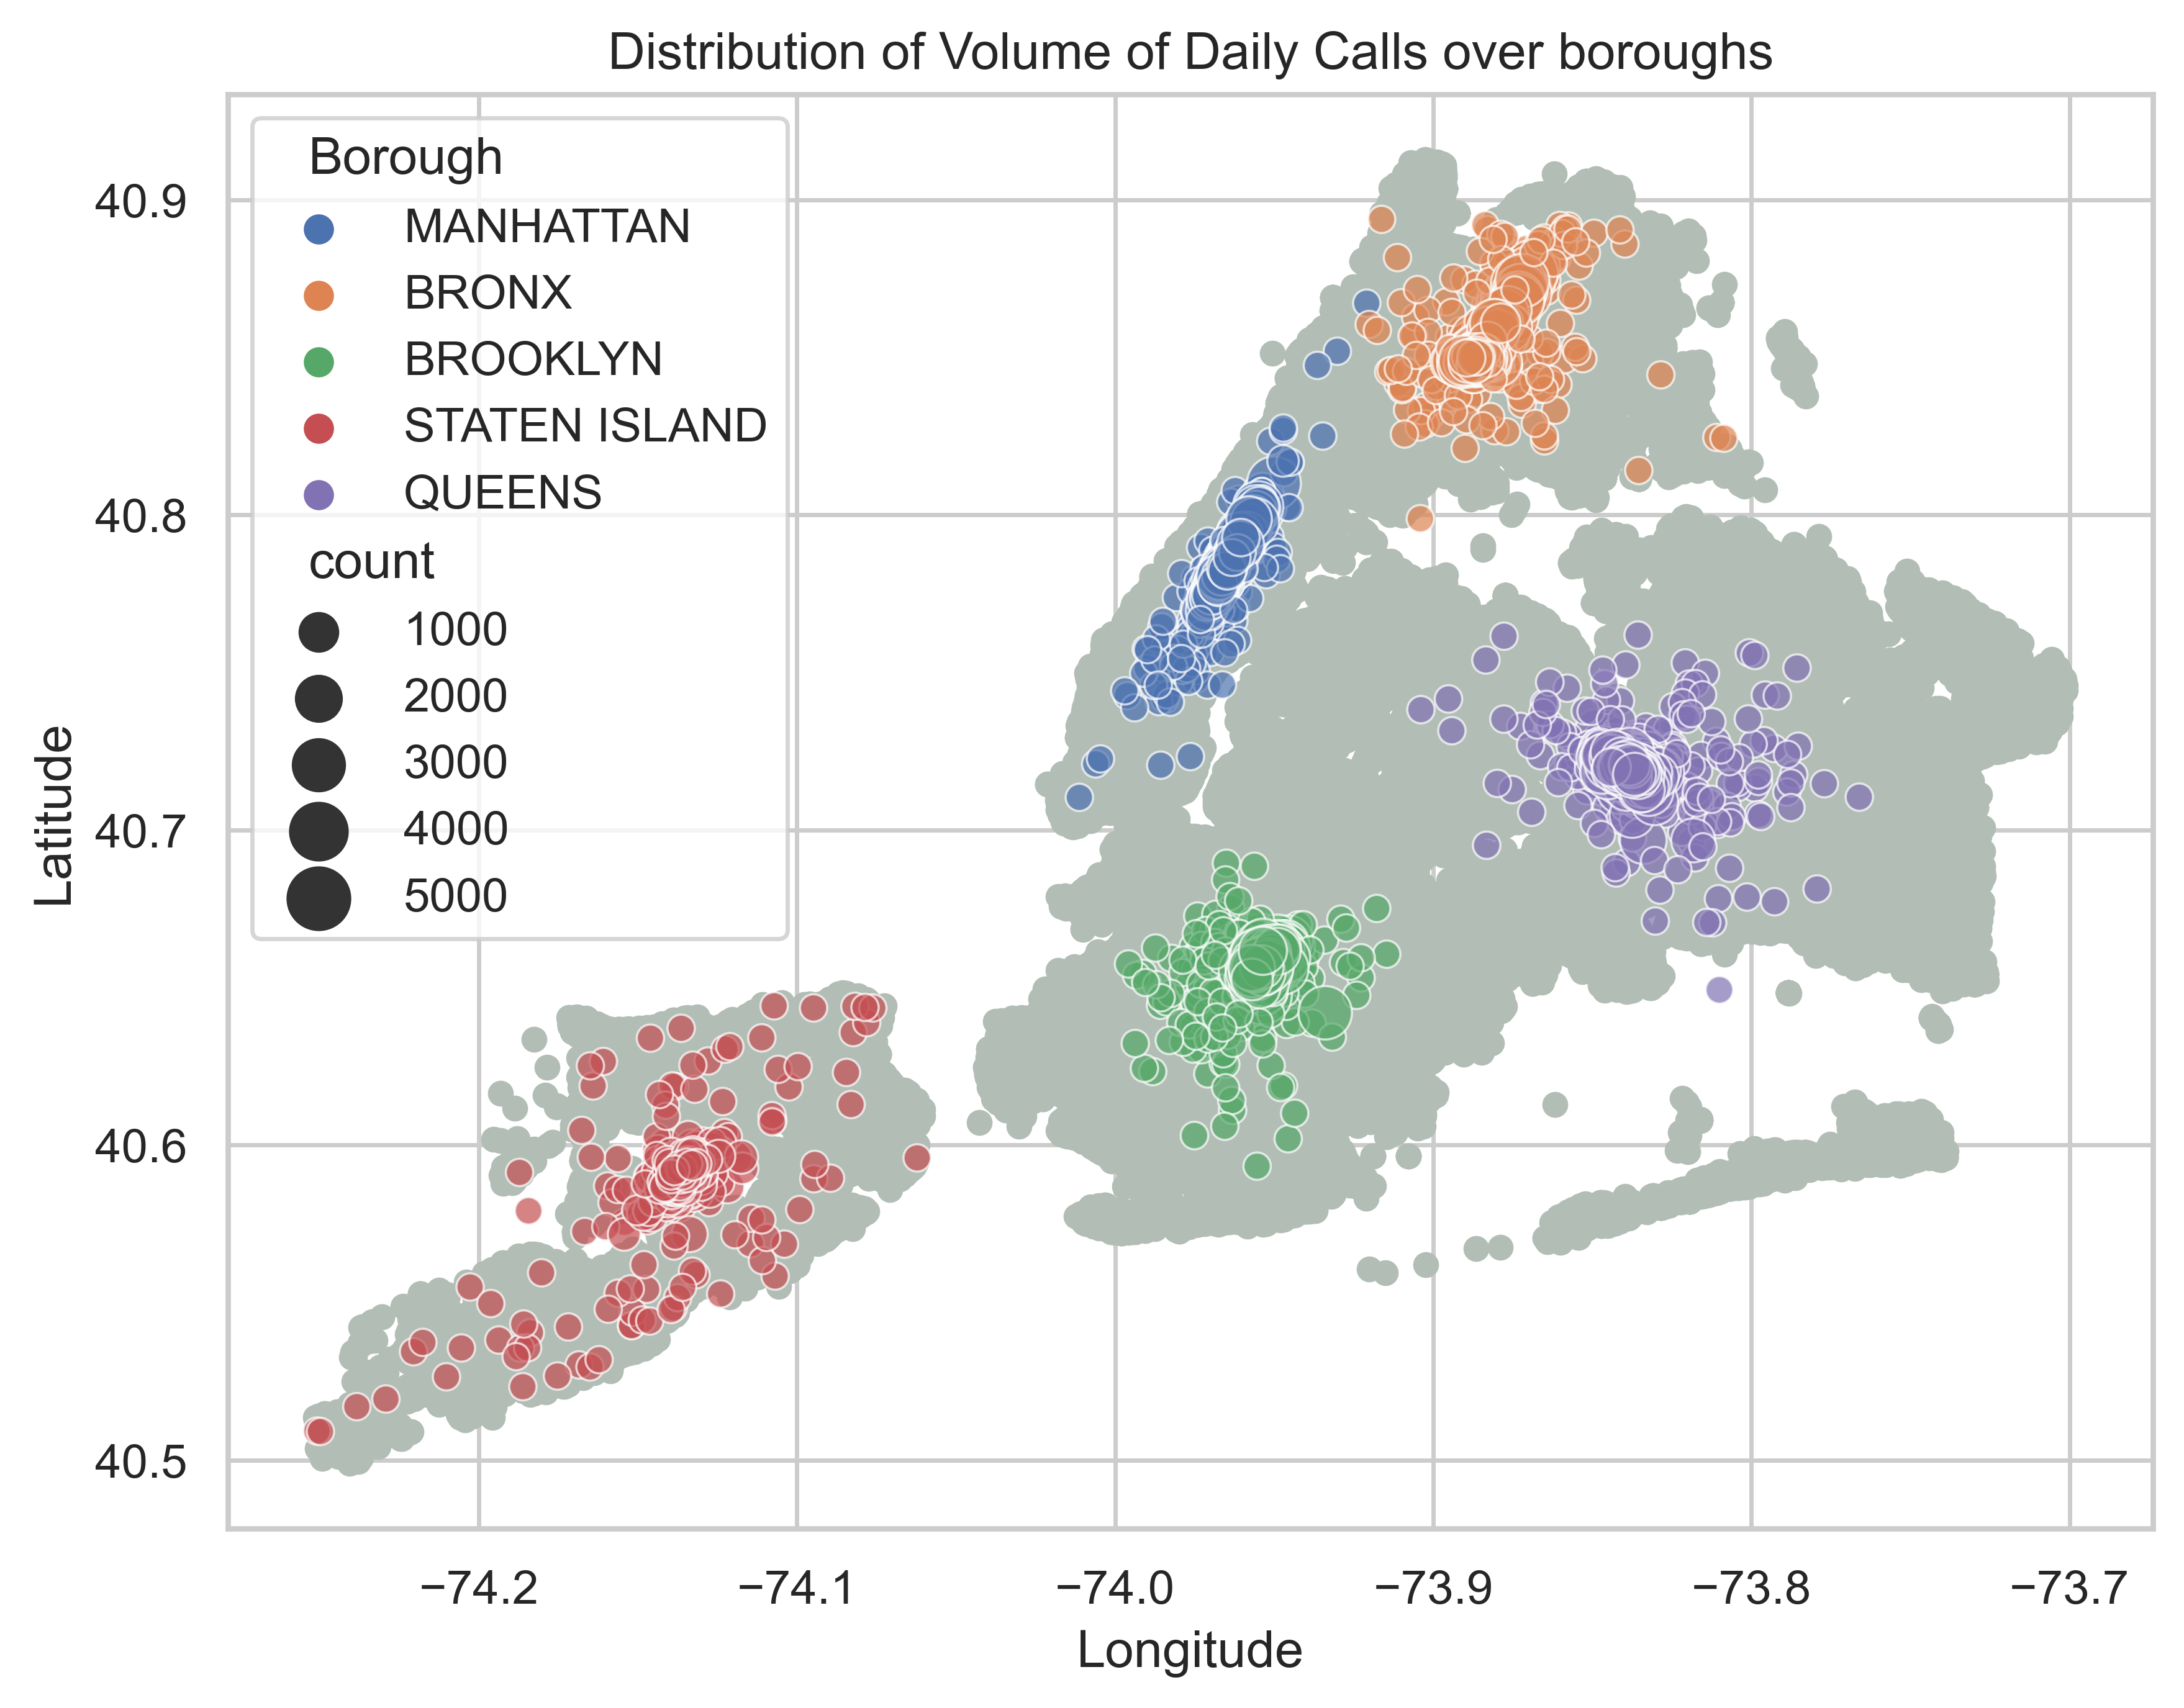

In [64]:
df_temp = df.select([
            pl.col('Created Date').cast(pl.Date),
            'Borough',
            'Longitude',
            'Latitude'
        ]).filter(
            pl.col('Borough') != 'Unspecified'
        ).group_by([
            'Created Date',
            'Borough'
        ]).agg(
            pl.col('Longitude').mean(),
            pl.col('Latitude').mean(),
            pl.count()
        ).to_pandas()

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=500)

sns.scatterplot(data=df.sample(100000).to_pandas(), x='Longitude', y='Latitude', linewidth=0, ax=ax)
ax.collections[0].set_facecolor('#B2BEB5')
sns.scatterplot(data=df_temp, x='Longitude', y='Latitude', hue='Borough', size='count', sizes=(40, 200), alpha=.7, ax=ax)

plt.title('Distribution of Volume of Daily Calls over boroughs')
plt.show()

# Time Series Analysis

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.api import qqplot
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from scipy import stats
from prophet import Prophet 

Importing plotly failed. Interactive plots will not work.


## Volume of Calls

In [43]:
# Consider only 'Created Date' with over 25 calls; x: Created Date, y: #Calls
time = df.select(pl.col('Created Date').cast(pl.Date))['Created Date'].value_counts().filter(pl.col('counts') >= 25).sort('Created Date', descending=False)

In [50]:
volume = pd.DataFrame({'ds': time['Created Date'], 'y':time['counts']})
volume['y_orig'] = volume['y'] # to save a copy of the original data.. 
# log-transform y
volume['y'] = np.log(volume['y'])

<AxesSubplot: xlabel='ds'>

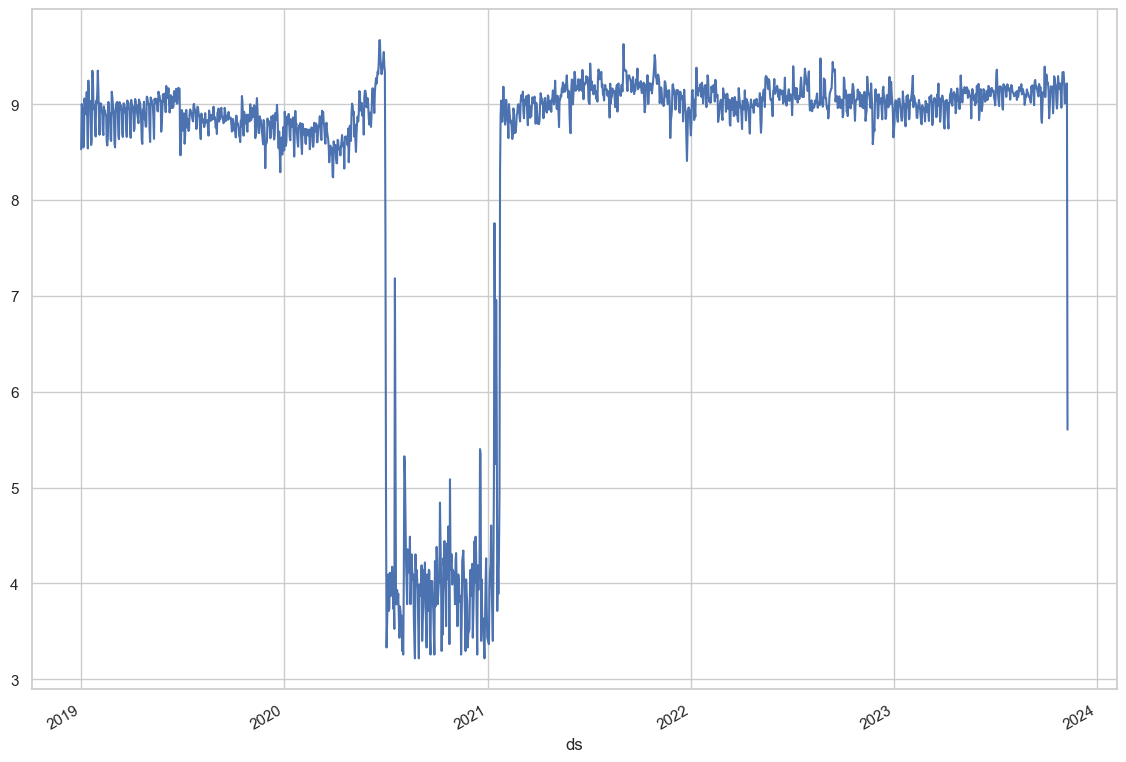

In [51]:
plt.rcParams['figure.figsize']=(14,10)
volume.set_index('ds').y.plot()

In [52]:
m = Prophet()
m.fit(volume)
future = m.make_future_dataframe(periods=60)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

14:41:42 - cmdstanpy - INFO - Chain [1] start processing
python(56100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
14:41:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1811,2024-01-04,8.530654,7.826770,9.264379
1812,2024-01-05,8.538482,7.822118,9.320696
1813,2024-01-06,8.481185,7.793973,9.212742
1814,2024-01-07,8.468655,7.743095,9.255715
1815,2024-01-08,8.620114,7.880103,9.339864


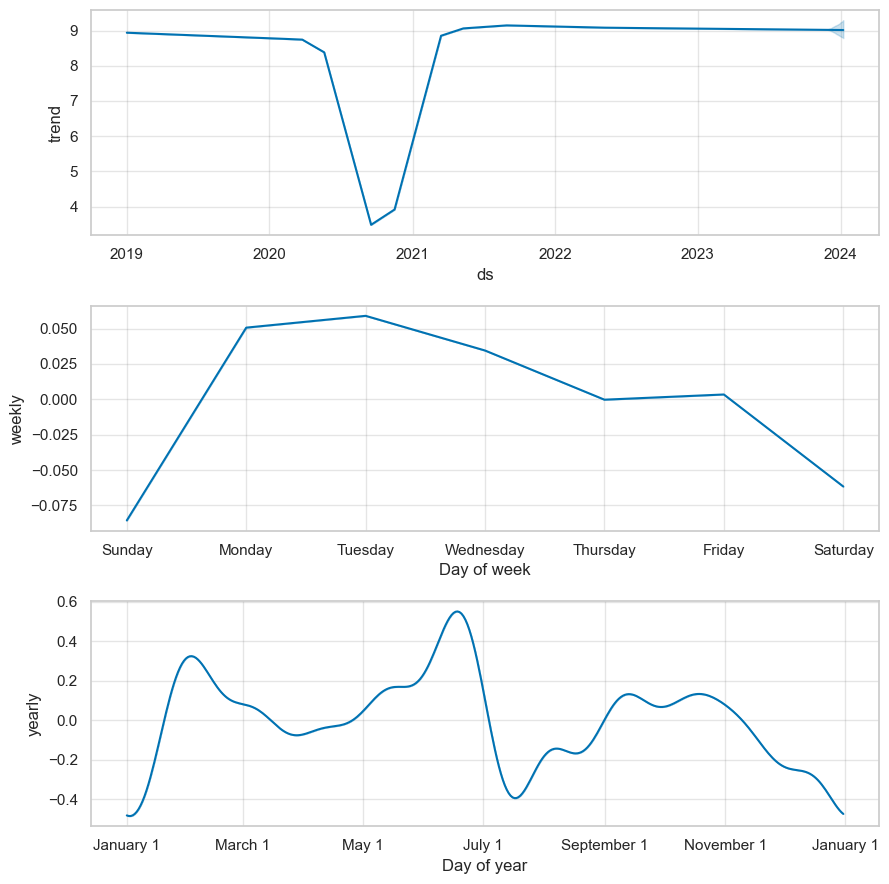

In [53]:
x = m.plot_components(forecast)

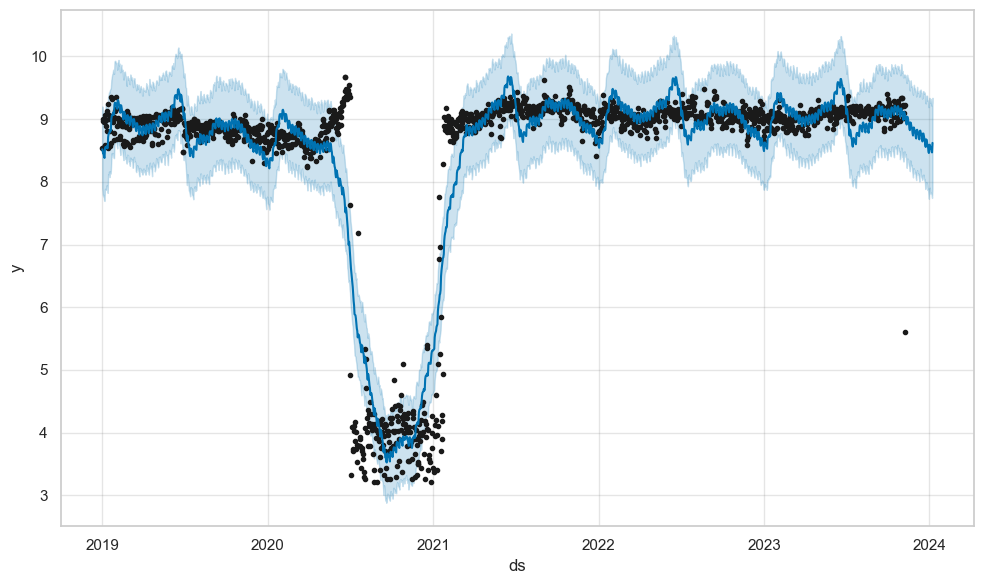

In [54]:
x = m.plot(forecast)

This chart shows the original data points (black dots), the predicted model (blue line), and the possible error in the forecast (blue shaded area). The chart displays the predicted values for the full data set plus new predicted values for January and February 2016. The shaded part of the graph shows the unsureness of the predicted values.

Overall, this graph allows us to compare the original data to the modeled prediction, look at the forecasted future values, and evaluate how unsure the predictions are.

0.8930198302126784


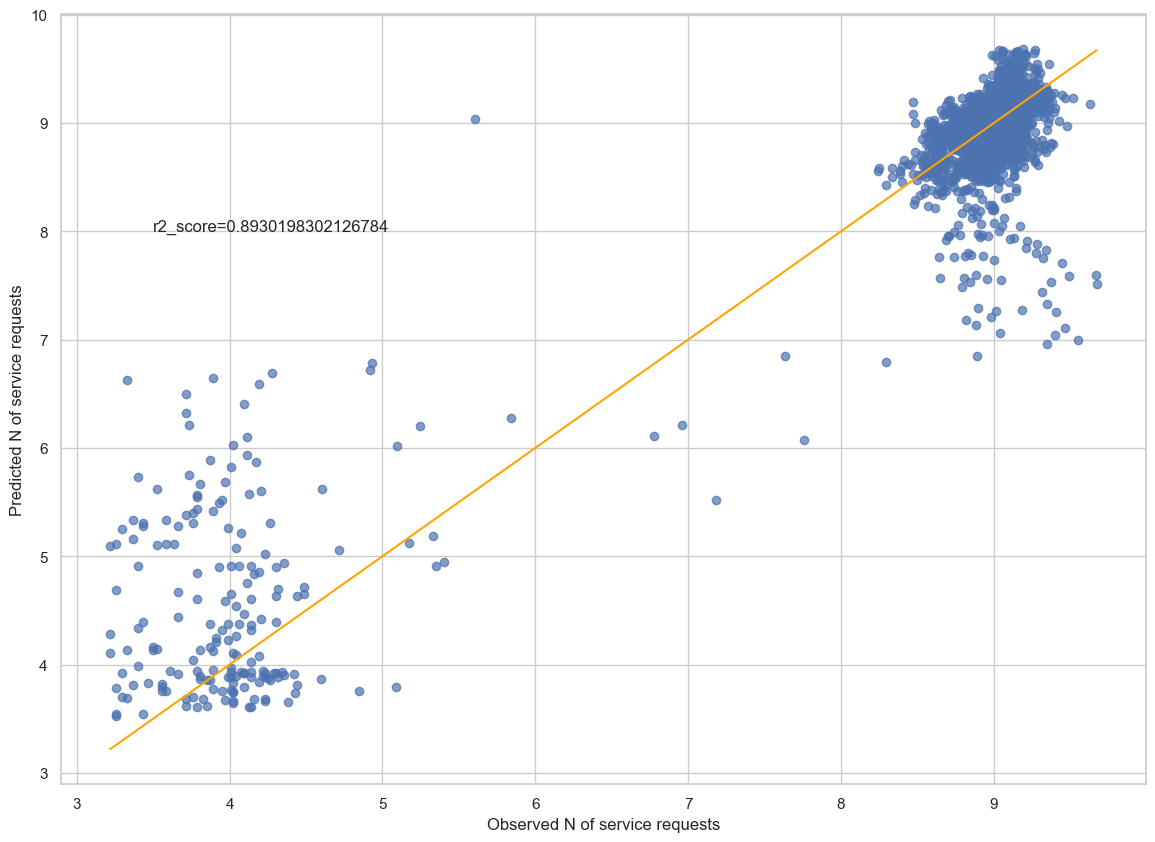

In [55]:
joined_df = volume.merge(forecast, left_on='ds', right_on='ds')
plt.scatter(joined_df.y, joined_df.yhat, alpha = 0.7)
r2_score(joined_df.y, joined_df.yhat)
print(r2_score(joined_df.y, joined_df.yhat))
plt.xlabel('Observed N of service requests')
plt.ylabel('Predicted N of service requests')
plt.text(3.5,8,"r2_score="+str(r2_score(joined_df.y, joined_df.yhat)))
plt.plot([joined_df.y.min(),joined_df.y.max()],[joined_df.y.min(),joined_df.y.max()], color='orange')